**MASK WEAR DETECTION WITH LOGISTIC REGRESSION in a semi-dynamic way :**

In [1]:
from torch.utils.data import DataLoader
import os
import cv2
import random

import torch
import numpy as np

from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

from torch.utils.data import DataLoader

import torch.nn as nn

import torch.nn.functional as F


class DataSet :

    def __init__(self,root,k,label):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        self.ROOT = root
        self.k = k # Number of images we want
        self.images = read_images(root,k)
        self.label = torch.from_numpy(np.array(label))

    def __len__(self):
        """return number of elements in our dataset"""
        
        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        img = self.images[idx]
        label = self.label[idx]

        return img, label
    

def read_images(root,k) :
        '''load all the images from a folder'''
        images, nb_images = [], 0
        for filename in os.listdir(root) :
            img = cv2.imread(os.path.join(root,filename))
            nb_images += 1
            if img is not None:
                img = img[:,:,::-1]/255 # To shuffle the color channels form BGR to RGB and /255 to normalize 
                images.append(img)
            if nb_images >= k :
                break
        return torch.from_numpy(np.array(images))
    
nb_of_images_taken = 200 # We take 200 images for each dataset

ds_uwm = DataSet('Um_1000',nb_of_images_taken,[0 for k in range(200)]) 
ds_wm = DataSet("Wm_1000",nb_of_images_taken,[1 for k in range(200)]) 

train_ds_wm, temp = random_split(ds_wm, [140, 60])
val_ds_wm, test_ds_wm = random_split(temp, [20, 40])

train_ds_uwm, temp = random_split(ds_uwm, [140, 60])
val_ds_uwm, test_ds_uwm = random_split(temp, [20, 40])

train_ds = train_ds_uwm + train_ds_wm
val_ds = val_ds_uwm + val_ds_wm
test_ds = test_ds_uwm + test_ds_wm


batch_size = 40

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

input_size = 1024*1024*3
num_classes = 2


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels.long()).item() / len(preds))

loss_fn = F.cross_entropy

class MWDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 1048576*3)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images.float())                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.float())                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MWDModel()

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Epoch [0], val_loss: 31.4236, val_acc: 0.9000
Epoch [1], val_loss: 1455.5815, val_acc: 0.5000
Epoch [2], val_loss: 458.1624, val_acc: 0.6000
Epoch [3], val_loss: 25.7478, val_acc: 0.9500
Epoch [4], val_loss: 16.0359, val_acc: 0.9500


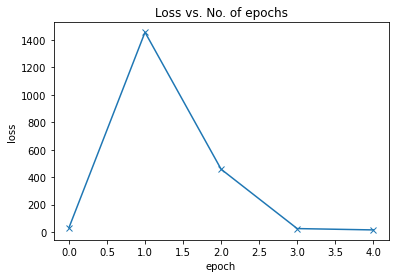

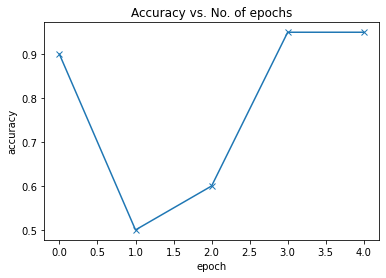

In [2]:
history = fit(5, 0.01, model, train_loader, val_loader)

import matplotlib.pyplot as plt


loss = [result['val_loss'] for result in history]
plt.plot(loss, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');
plt.show()


accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');
plt.show()

# See how it works with the testing set :

In [3]:
test_loader = DataLoader(test_ds, batch_size=80)
result = evaluate(model, test_loader)
result

{'val_loss': 45.18352127075195, 'val_acc': 0.9375}

# Testing with individual images :

In [4]:
def predict_image(img, model):
    '''img must be in type torch.from_numpy(np.array(images))'''
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

opencv_frame_0.jpeg written!
opencv_frame_1.jpeg written!
opencv_frame_2.jpeg written!
opencv_frame_3.jpeg written!
Escape hit, closing...


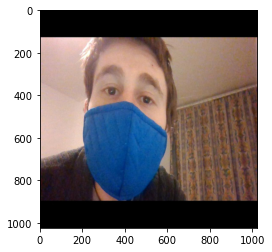

Predicted: 1


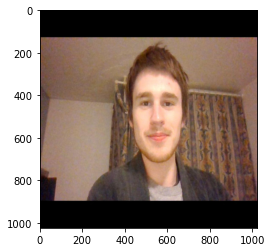

Predicted: 0


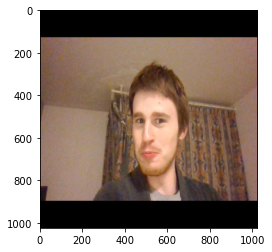

Predicted: 0


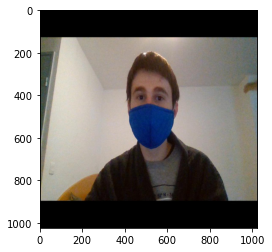

Predicted: 0


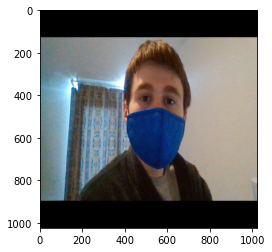

Predicted: 0


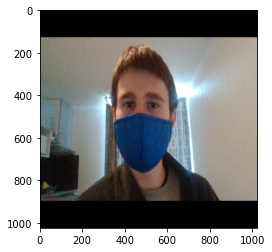

Predicted: 0


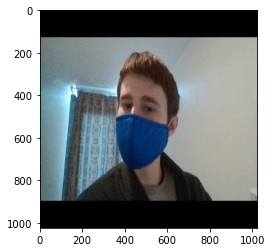

Predicted: 0


In [5]:
import cv2
from PIL import Image

cam = cv2.VideoCapture(0)

cv2.namedWindow("Take a photo:")

img_counter = 0  

hsize, basewidth = 1024, 1024

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("Take a photo:", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.jpeg".format(img_counter)
        cv2.imwrite(img_name, frame)
        img = Image.open("opencv_frame_{}.jpeg".format(img_counter))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)
        
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #_,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
        
        #contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        #cnt = contours[0]
        #x,y,w,h = cv2.boundingRect(cnt)
        
        #crop = img[y:y+h,x:x+w]
        
        
        
        img.save("Myself/opencv_frame_{}.jpeg".format(img_counter))
        os.remove("opencv_frame_{}.jpeg".format(img_counter))
        
        
        
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

import fnmatch # To count number of files (every kind) in a directory

new_imgs = read_images("Myself",len(fnmatch.filter(os.listdir("Myself"),'*')))

for i in range(len(new_imgs)) :
    plt.imshow(new_imgs[i])
    plt.show()
    print('Predicted:', predict_image(new_imgs[i].float(), model))

In [9]:
img = cv2.imread("Myself/keepit.jpeg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
        
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)
crop = img[y:y+h,x:x+w]
cv2.imwrite('sofwinres.png',crop)
crop

array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)

:)